In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from cosine_annealing import CosineAnnealingScheduler
from keras.layers import BatchNormalization
import pickle
from keras.regularizers import l2
from  scipy import ndimage
import numpy as np

#### Dataset


Load dataset + One-hot encoding + Normalization

In [2]:
def load_dataset(noise_ratio=0, sym=True):
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    n_classes = 10

    if noise_ratio > 0:
        trainY_original = np.copy(trainY)
        if not sym:
            # Asymetric noise
            source_class = [9, 2, 3, 5, 4]
            target_class = [1, 0, 5, 3, 7]

            for s, t in zip(source_class, target_class):
                cls_idx = np.where(trainY_original == s)[0]
                n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
                noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=False)
                trainY[noisy_sample_index] = t
        else:
          # Symmetric noise

            n_samples = trainY.shape[0]
            n_noisy = int(noise_ratio * n_samples / 100)
            class_index = [np.where(trainY_original == i)[0] for i in range(n_classes)]
            class_noisy = int(n_noisy / n_classes)

            noisy_idx = []
            for d in range(n_classes):
                noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=False)
                noisy_idx.extend(noisy_class_index)

            for i in noisy_idx:
                class_ind = trainY_original[i]
                other_class_list = list(range(n_classes))
                other_class_list.remove(class_ind)
                other_class = np.random.choice(other_class_list)
                trainY[i] = other_class

    # One-hot encoding
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # Normalize to [0,1]
    trainX = trainX.astype('float32') / 255.0
    testX = testX.astype('float32') / 255.0

    return trainX, trainY, testX, testY

#### Model

Imortant functions

In [3]:
def train(model, trainX, trainY, testX, testY):

	generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

	train_data = generator.flow(trainX, trainY, batch_size=64)

	results = model.fit(train_data, epochs=100, validation_data=(testX, testY), verbose=1)

	return results

def evaluate(model, testX, testY):
    _, acc = model.evaluate(testX, testY, verbose=0)

    print(f"The model achieved a final accuracy of {acc*100:.2f}%")

def plot_results(history):
	plt.title('Cross Entropy Loss')
	plt.plot(history['loss'], color='blue', label='Training loss')
	plt.plot(history['val_loss'], color='orange', label='Validation/test loss')
	plt.legend()
	plt.show()

	plt.title('Classification Accuracy')
	plt.plot(history['accuracy'], color='blue', label='Training accuracy')
	plt.plot(history['val_accuracy'], color='orange', label='Validation/test accuracy')
	plt.legend()
	plt.show()

In [4]:
def save_model(filename, model):
    filename = '/content/' + filename
    pickle.dump(model, open(filename, 'wb'))

def save_history(filename, history):
    filename = '/content/' + filename
    pickle.dump(history, open(filename, 'wb'))

def load_model(filename):
    filename = '/content/' + filename
    model = pickle.load(open(filename, 'rb'))
    return model

def load_history(filename):
    filename = '/content/' + filename
    history = pickle.load(open(filename, 'rb'))
    return history

Baseline model

In [5]:
def dropout_model():
    # Create architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    total_steps = int(trainX.shape[0]/64) * 100
    decay_steps = total_steps*0.8
    initial_learning_rate = 0.0001
    warmup_steps = 1000
    target_learning_rate = 0.1
    alpha = 0.001

    lr_warmup_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
        warmup_steps=warmup_steps,alpha = alpha
    )
    # Optimization method
    opt = SGD(learning_rate=lr_warmup_decayed_fn, momentum=0.9)

    # Compile model and choose loss type
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
trainX, trainY, testX, testY = load_dataset(noise_ratio=40, sym=True)

170498071/170498071 [==============================] - 13s 0us/step


In [7]:
model = dropout_model()
results = train(model, trainX, trainY, testX, testY)

Epoch 1/100
782/782 [==============================] - 46s 49ms/step - loss: 2.3843 - accuracy: 0.1940 - val_loss: 1.8743 - val_accuracy: 0.3244
Epoch 2/100
782/782 [==============================] - 36s 46ms/step - loss: 2.1015 - accuracy: 0.2832 - val_loss: 1.6205 - val_accuracy: 0.4984
Epoch 3/100
782/782 [==============================] - 34s 44ms/step - loss: 2.0625 - accuracy: 0.3125 - val_loss: 1.4429 - val_accuracy: 0.5669
Epoch 4/100
782/782 [==============================] - 36s 46ms/step - loss: 2.0273 - accuracy: 0.3403 - val_loss: 1.4781 - val_accuracy: 0.5580
Epoch 5/100
782/782 [==============================] - 37s 47ms/step - loss: 2.0003 - accuracy: 0.3577 - val_loss: 1.3344 - val_accuracy: 0.6120
Epoch 6/100
782/782 [==============================] - 37s 47ms/step - loss: 1.9839 - accuracy: 0.3723 - val_loss: 1.2713 - val_accuracy: 0.6502
Epoch 7/100
782/782 [==============================] - 35s 45ms/step - loss: 1.9673 - accuracy: 0.3857 - val_loss: 1.3125 - val_ac

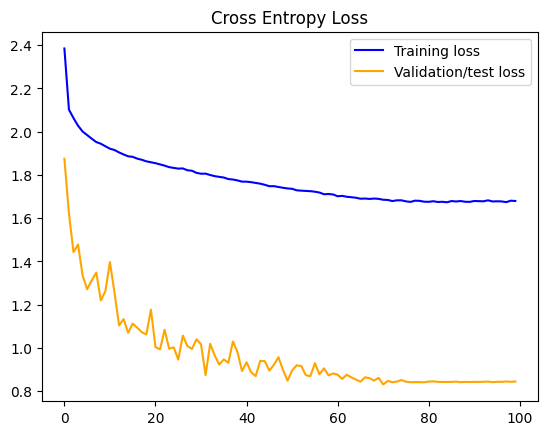

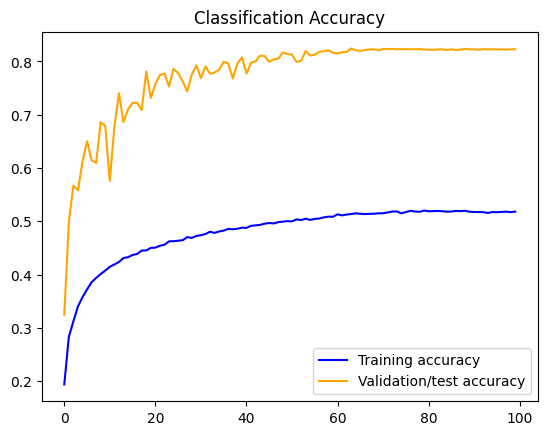

The model achieved a final accuracy of 82.27%


In [8]:
plot_results(results.history)
evaluate(model, testX, testY)

In [10]:
save_model('CE_noisy_model_40_sym_dropout', model)
save_history('CE_noisy_model_40_sym_dropout_hist', results.history)